In [2]:
import optuna
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from optuna import Trial, visualization
from sklearn.metrics import mean_squared_error

In [3]:
stock_data = pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv', parse_dates=['Date'])
stock_data.sort_values(by='Date', ascending=True, inplace=True)
stock_data = stock_data.reset_index()
stock_data.rename(columns={'Turnover (Lacs)': 'Turnover'}, inplace=True)
stock_data['Price'] = (stock_data['Turnover'] / stock_data['Total Trade Quantity']) * 100000
stock_data.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover,Price
0,1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,156.296192
1,1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,156.348618
2,1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,159.329095
3,1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,161.206694
4,1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,159.127498


In [4]:
def lag_feature(df, lags, col):
    tmp = df[['Date', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['Date', col+'_lag_'+str(i)]
        shifted['Date'] += datetime.timedelta(days=i)
        df = pd.merge(df, shifted, on=['Date'], how='left')
    return df

stock_data = lag_feature(stock_data, [1, 2, 3, 4, 5], 'Price')

In [5]:
stock_data['Price_Mva'] = stock_data['Price'].rolling(window=5).mean()
stock_data['Price_Std'] = stock_data['Price'].rolling(window=5).std()

stock_data.fillna(0, inplace=True)
stock_data.drop(columns=['index'], inplace=True)

x_train = stock_data[stock_data['Date']<'2018-10-01'].drop(['Turnover', 'Date', 'Total Trade Quantity', 'Price', 'Open', 'High', 'Low', 'Last', 'Close'], axis=1)
y_train = stock_data[stock_data['Date']<'2018-10-01']['Price']
x_valid = stock_data[stock_data['Date']>='2018-10-01'].drop(['Turnover', 'Date', 'Total Trade Quantity', 'Price', 'Open', 'High', 'Low', 'Last', 'Close'], axis=1)
y_valid = stock_data[stock_data['Date']>='2018-10-01']['Price']

In [6]:
def objective(trial):
    
    train_x, test_x, train_y, test_y = x_train, x_valid, y_train, y_valid

    param = {
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBRegressor(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-02-24 17:30:21,500] A new study created in memory with name: no-name-1381e16d-5312-49e5-86d0-847bfe08bfc8


[17:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:22,469] Trial 0 finished with value: 17.958044585735028 and parameters: {'lambda': 0.30438138919757785, 'alpha': 0.028464082056271926, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 289}. Best is trial 0 with value: 17.958044585735028.


[17:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:23,065] Trial 1 finished with value: 9.015359641772644 and parameters: {'lambda': 0.04644225816869773, 'alpha': 0.10218985043588358, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 3000, 'max_depth': 15, 'min_child_weight': 117}. Best is trial 1 with value: 9.015359641772644.
[I 2021-02-24 17:30:23,248] Trial 2 finished with value: 14.509675320812272 and parameters: {'lambda': 0.0029433862506498833, 'alpha': 0.03593802352040922, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 186}. Best is trial 1 with value: 9.015359641772644.


[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:23,334] Trial 3 finished with value: 17.194611980200246 and parameters: {'lambda': 0.2760634336438481, 'alpha': 0.03807436705069667, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.018, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 228}. Best is trial 1 with value: 9.015359641772644.
[I 2021-02-24 17:30:23,483] Trial 4 finished with value: 14.901436584054442 and parameters: {'lambda': 7.023110777747735, 'alpha': 0.3001824447814212, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 151}. Best is trial 1 with value: 9.015359641772644.


[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:23,649] Trial 5 finished with value: 13.406494407272517 and parameters: {'lambda': 0.3983615485598276, 'alpha': 9.017144561524532, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 15, 'min_child_weight': 144}. Best is trial 1 with value: 9.015359641772644.
[I 2021-02-24 17:30:23,752] Trial 6 finished with value: 28.83338219348702 and parameters: {'lambda': 0.010363126069815903, 'alpha': 0.35220634390342515, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 290}. Best is trial 1 with value: 9.015359641772644.


[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:23,972] Trial 7 finished with value: 16.273868560146894 and parameters: {'lambda': 3.1908249218473754, 'alpha': 0.1366292200505892, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 126}. Best is trial 1 with value: 9.015359641772644.


[17:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:25,625] Trial 8 finished with value: 7.9348794956052835 and parameters: {'lambda': 0.0032126974836288584, 'alpha': 0.014212707108014724, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 64}. Best is trial 8 with value: 7.9348794956052835.
[I 2021-02-24 17:30:25,749] Trial 9 finished with value: 14.756505377309225 and parameters: {'lambda': 3.1709310830314306, 'alpha': 0.1277552675683061, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 203}. Best is trial 8 with value: 7.9348794956052835.


[17:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:26,277] Trial 10 finished with value: 7.289525746121051 and parameters: {'lambda': 0.0011722305563041941, 'alpha': 0.002195540046366874, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 14}. Best is trial 10 with value: 7.289525746121051.


[17:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:26,830] Trial 11 finished with value: 8.20277507426145 and parameters: {'lambda': 0.001249065431077619, 'alpha': 0.0010420029945308782, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 26}. Best is trial 10 with value: 7.289525746121051.


[17:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:27,271] Trial 12 finished with value: 5.572913772782312 and parameters: {'lambda': 0.005331540989905977, 'alpha': 0.001984456034092378, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 12 with value: 5.572913772782312.


[17:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:27,559] Trial 13 finished with value: 5.776376438496232 and parameters: {'lambda': 0.01667391248890321, 'alpha': 0.0012153054698992942, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 12 with value: 5.572913772782312.


[17:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:27,842] Trial 14 finished with value: 5.5517759039553845 and parameters: {'lambda': 0.02332218401259872, 'alpha': 0.0035552370115647567, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 54}. Best is trial 14 with value: 5.5517759039553845.
[I 2021-02-24 17:30:27,970] Trial 15 finished with value: 6.327544327179448 and parameters: {'lambda': 0.03725528435058898, 'alpha': 0.004732943574656593, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 68}. Best is trial 14 with value: 5.5517759039553845.


[17:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:28,246] Trial 16 finished with value: 5.710954963412133 and parameters: {'lambda': 0.0075140683767987385, 'alpha': 0.005608810137820723, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 63}. Best is trial 14 with value: 5.5517759039553845.


[17:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:28,496] Trial 17 finished with value: 8.849690565530905 and parameters: {'lambda': 0.05862090929384243, 'alpha': 2.4673188214132282, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 36}. Best is trial 14 with value: 5.5517759039553845.


[17:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:28,927] Trial 18 finished with value: 5.791737883706714 and parameters: {'lambda': 0.0035688765976260575, 'alpha': 0.004872789763956748, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 13, 'min_child_weight': 92}. Best is trial 14 with value: 5.5517759039553845.
[I 2021-02-24 17:30:29,063] Trial 19 finished with value: 6.395545334225523 and parameters: {'lambda': 0.01992935243789598, 'alpha': 0.00212336797119551, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 14 with value: 5.5517759039553845.


[17:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:29,372] Trial 20 finished with value: 6.064960238313446 and parameters: {'lambda': 0.10906646438076216, 'alpha': 0.0106574597885097, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 3000, 'max_depth': 13, 'min_child_weight': 44}. Best is trial 14 with value: 5.5517759039553845.


[17:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:29,637] Trial 21 finished with value: 5.702846029540039 and parameters: {'lambda': 0.006863857832087571, 'alpha': 0.004679670827597479, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 86}. Best is trial 14 with value: 5.5517759039553845.


[17:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:29,909] Trial 22 finished with value: 5.713593039594238 and parameters: {'lambda': 0.006277086826998729, 'alpha': 0.0021998424362655237, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 85}. Best is trial 14 with value: 5.5517759039553845.


[17:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:30,179] Trial 23 finished with value: 5.801760688855349 and parameters: {'lambda': 0.0164103792964376, 'alpha': 0.013040717111989699, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 99}. Best is trial 14 with value: 5.5517759039553845.


[17:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-02-24 17:30:30,618] Trial 24 finished with value: 5.693128379799537 and parameters: {'lambda': 0.0017265674002904902, 'alpha': 0.0012626533331243678, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 14 with value: 5.5517759039553845.


Number of finished trials: 25
Best trial: {'lambda': 0.02332218401259872, 'alpha': 0.0035552370115647567, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 54}


In [7]:
model = XGBRegressor(**study.best_trial.params)

model.fit(
x_train, 
y_train, 
eval_metric="rmse", 
eval_set=[(x_train, y_train), (x_valid, y_valid)], 
verbose=True)

[17:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:173.51	validation_1-rmse:217.885
[1]	validation_0-rmse:171.102	validation_1-rmse:214.795
[2]	validation_0-rmse:168.727	validation_1-rmse:211.763
[3]	validation_0-rmse:166.386	validation_1-rmse:208.758
[4]	validation_0-rmse:164.078	validation_1-rmse:205.81
[5]	validation_0-rmse:161.801	validation_1-rmse:202.889
[6]	validation_0-rmse:159.557	validation_1-rmse:200.022
[7]	validation_0-rmse:157.344	validation_1-rmse:197.181
[8]	validation_0-rmse:155.161	validation_1-rmse:194.399
[9]	validation_0-rmse:153.009	validation_1-rmse:191.624
[10]	validation_0-rmse:150.887	validation_1-rmse:188.874
[11]	validation_0-rmse:148.794	validation_1-rmse:186.228
[12]	validation_0-rmse:146.731	validation_1-rmse:183.549
[13]	validation_0-rmse:144.696	validation_1-rmse:180.976
[14]	validation_0-rmse:142.69	validation_1-rmse:178.351
[15]	validation_0-rmse:140.712	

XGBRegressor(alpha=0.0035552370115647567, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             gamma=0, importance_type='gain', lambda=0.02332218401259872,
             learning_rate=0.014, max_delta_step=0, max_depth=4,
             min_child_weight=54, missing=None, n_estimators=3000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1.0, verbosity=1)

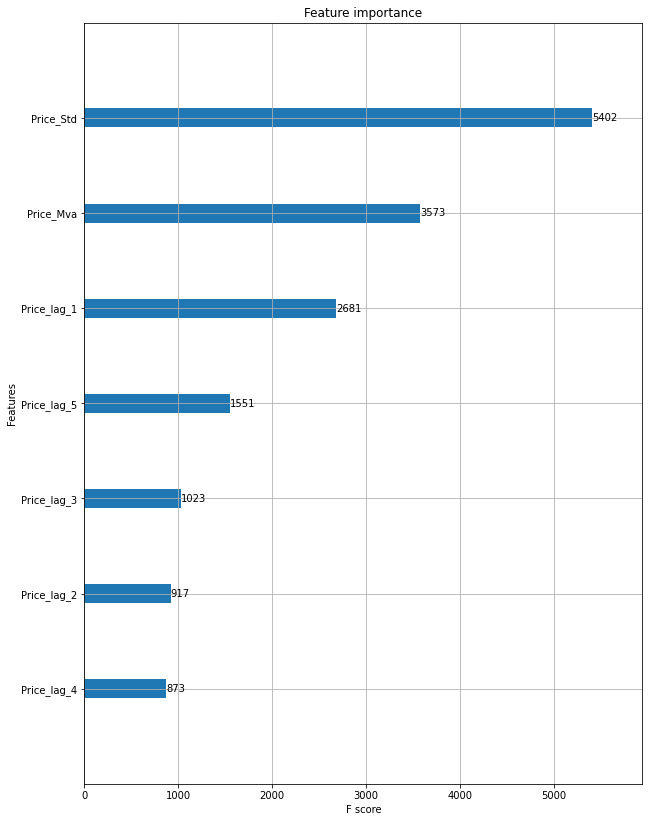

In [8]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))